# Analysis pipeline : multi images to axon/myeling prediction, myelin segemntation and statistic
This pipeline generates for each image, the prediction mask from a RGB image (using a post convertion) and apply the myelin segmentation. Finally it creates a dataframe with characteristics of each identified fiber.<br>
In last step, the dataframes of each individual images are merged to create a large dataframe then distribution histograms are plotted
This analysis doesn't requires ground truth data

1. 1-1 import the model
1. 1-2 Choose the folder contain all the images 
2. 2-1 Create function "process one image"
2. 2-2 loop over the images and create the dataframe
3. Statistic and plots
4. Sanity check : plot the mask for a specific image

This notebook is used to analysis multiple images at once. The folder structure should be following:
- project_folder
        - name_1.png
        - name_2.png
        - .....
The easiest way to start is to use the test folder current location: /home/thibault/Documents/Thibault_Python_dev/Unet_TT/demo_multi_images

In [5]:
import os
from PIL import Image
from PIL import ImageOps
import numpy as np
import skimage.io as io
import math
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd

from tkinter import filedialog
from tkinter import Tk
%matplotlib inline

In [6]:
import utility.Performance_measurement as Perf_m
import utility.Apply_model as Apply_model
from utility.Utility import Image_2_np, Import_image, get_list_img
import utility.Myelin_segmentation_utility as ms_uti
from utility.utility_plot import *


### 1.1- Import model only

In [7]:
# import keras model

# defualt
model_path = './Models/model_in_use.h5'
# or choose
#model_path = ''

model = Apply_model.Import_model(model_path = model_path)

### 1.2- Choose the folder containing all the image to analyse

In [8]:
image_list, dir_name = get_list_img(ext='.jpg')
print ('images directory: ', dir_name)

images directory:  /home/thibault/Documents/Data/ADS/18_06_CC_S5_ADS_Training/Unet_prediction


### 2 Apply model, segment myelin and create dataframe

The function process_one_image will:
 - import the image from img_path
 - predict the class using Unet_by_patches
 - create a mask
 - save the image in the same location as the original with _unet nametag
 - preform the myelin segementation
 - finally extract all the morphological characteristics for the axons detected
 
The loop will do the job for all image image contain in image_list

Lastly, all the data are save in the

In [9]:
# 2-1 Apply the model and myelin segmentaion on one image
def process_one_image (img_path, model, pixel_size):
    
    img = Image.open(img_path)
    pred_image = Apply_model.Unet_by_patches(img, model, patch_size = 256, overlap=64)
    
    mask = np.argmax(pred_image, axis=-1)
    mask=127*mask.astype(np.uint8)
    
    # save 
    folder_path, name = os.path.split(img_path)
    base_name  = name.split('.')[0]
    io.imsave(folder_path + '/' + base_name + '_unet.png', mask)
    
    # Myelin segmentation
    fiber_pred_seg = ms_uti.quick_myelin_seg(mask)
    _, _, label_fiber_pred, label_axon_pred  = ms_uti.clean_up (fiber_pred_seg, mask)
    
    # Create dataframe
    df = Perf_m.Fiber_morpho(label_fiber_pred, label_axon_pred, pixel_size = pixel_size)
    
    return df

In [10]:
# 2-2 loop over the images and merge the dataframes

# Choose
pixel_size = 0.11

df_list=[]
for img_path in image_list:
    
    df = process_one_image(img_path, model, pixel_size= pixel_size)
    df_list.append(df)
    
df = result = pd.concat(df_list)
print('dataframe size: ', df.shape)

100%|██████████| 104/104 [00:02<00:00, 39.40it/s]


dataframe size:  (8918, 6)


In [7]:
# save the dataframe 

base_name = os.path.join(dir_name,'dataframe')
# as csv
file_name_csv  =base_name + '.csv'
df.to_csv(file_name_csv) 

# as pickle
file_name_pkl = base_name + '.pkl'
df.to_pickle(file_name_pkl)

# open the pickle
#unpickled_df = pd.read_pickle(file_name_pkl)

# open the csv
#uncsv_df= pd.read_csv(file_name_csv)

## 3- Statistic and plots

- Plot the histogram distribution of the predicted feature.
- predicted features are axon diameter, myelin thickness, gratio
- Indicate the position of the peak value

In [8]:
# Directory to save the plots

# Choose
Auto = True # True: plots will be saved where images are (dir_name, see In[4]). 
            # False: you will be asked where to save the plots

if not Auto:
    root = Tk()
    root.withdraw()# we don't want a full GUI, so keep the root window from appearing
    dir_name =  filedialog.askdirectory(initialdir = '/home/thibault/Documents/Data/ADS/',\
                                                      title = 'choose directory location to save the plot')

print (f'Data will be saved in: "{dir_name}"')

Data will be saved in: "/home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/Data/demo_multi_images"


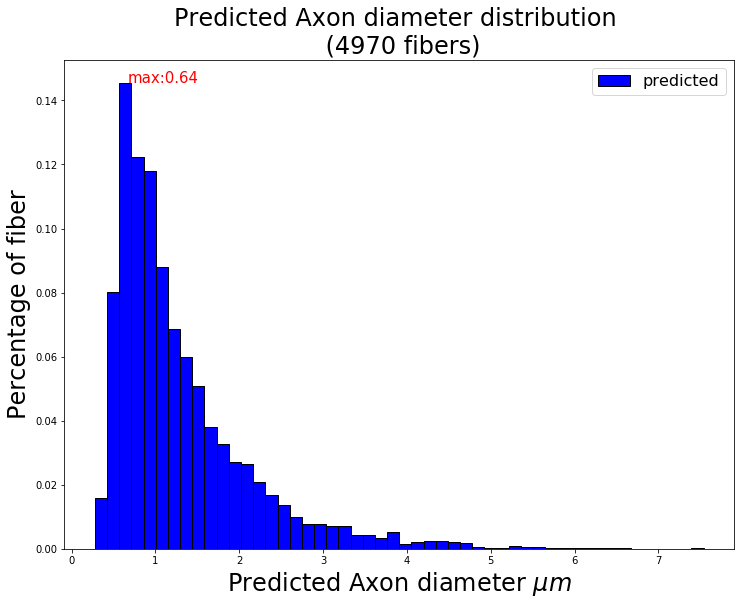

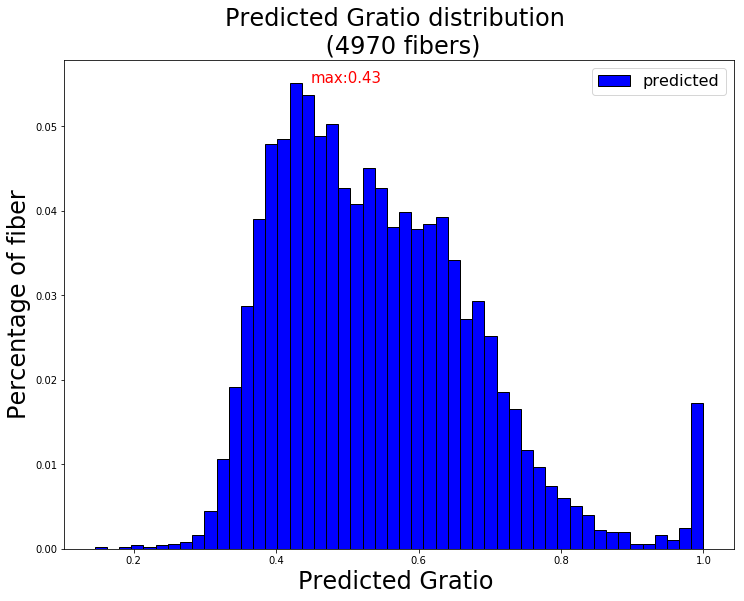

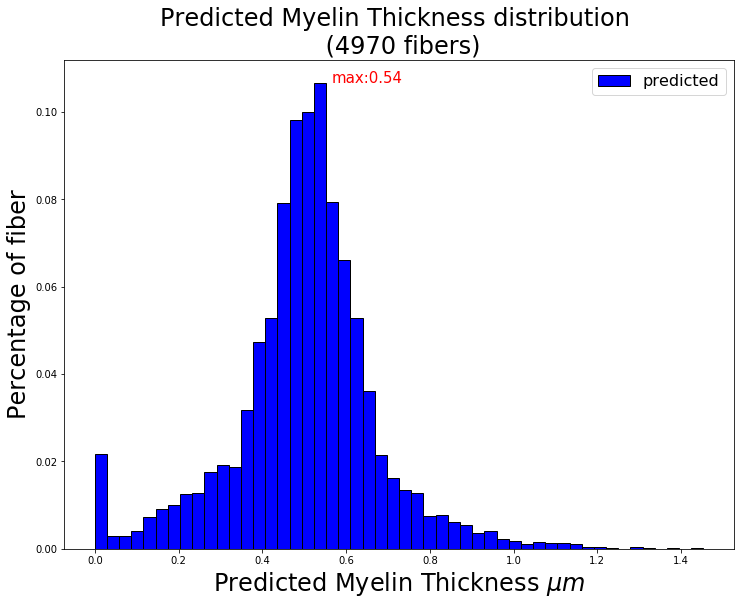

In [9]:
# loop over the different feature  to plot all at once
%matplotlib inline
# Choose
specific_tag= 'CST'# prefix for plot name 

measured_option = {'Axon diameter':('diam_a','${\mu}m$' ), 'Gratio':('gratio',''),
                   'Myelin Thickness':('myelin_thick','${\mu}m$')}


fiber_number = df.shape[0]
for feature in measured_option.keys():
    
    pred = measured_option[feature][0]
    unit = measured_option[feature][1]
    measured = feature
    
    # plot 1
    title_1 = 'Predicted {0} distribution \n ({1} fibers)'. format(measured, fiber_number)
    x_label_1 = 'Predicted {0} {1}'. format(measured, unit)
    y_label_1 = 'Percentage of fiber'

    pred_xx = df[pred]
    bins,fig = bar_plot_dist_1_categ(pred_xx, legend='predicted', bins=50, display_max=True)
    plt.xlabel(x_label_1, fontsize=24); plt.ylabel(y_label_1, fontsize=24)
    plt.title(title_1, fontsize=24)
    plt.show()
    save_plot_name = os.path.join(dir_name, 'plot1_{0}_{1}'.format(specific_tag,feature))
    fig.savefig(save_plot_name)


### 4- Sanity Check section
Allow you to plot what the myelin segmenation mask looks like


In [10]:
# list of the images you can plot
image_list

['/home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/Data/demo_multi_images/fig1.jpg',
 '/home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/Data/demo_multi_images/fig2.jpg',
 '/home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/Data/demo_multi_images/fig3.jpg',
 '/home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/Data/demo_multi_images/fig4.jpg']

In [11]:
# Sanity Check

# Choose
i=0 # Choose the image you want to try out from the previous list (see In[21])

img_path = image_list[i]
img = Image.open(img_path)
pred_image = Apply_model.Unet_by_patches(img, model, patch_size = 256, overlap=64)
    
mask = np.argmax(pred_image, axis=-1)
mask=127*mask.astype(np.uint8)

# Myelin segmentation
fiber_pred_seg = ms_uti.quick_myelin_seg(mask)
_, _, label_fiber_pred, label_axon_pred  = ms_uti.clean_up (fiber_pred_seg, mask)

100%|██████████| 108/108 [00:02<00:00, 38.81it/s]


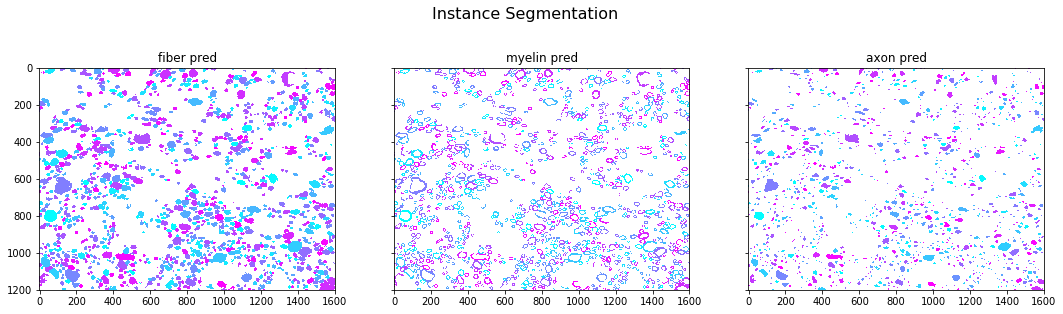

In [12]:
# Sanity check
# Display the segmentation of the fiber
label_myelin_pred = label_fiber_pred-label_axon_pred
mycolor=ms_uti.random_cmap(label_fiber_pred.max(),'cool')
fig, ax =  plt.subplots(figsize = (18,5),nrows=1, ncols=3, sharex=True, sharey=True)
fig.suptitle('Instance Segmentation', fontsize = 16)
ax=ax.flatten()
ax[0].imshow(label_fiber_pred, cmap =mycolor)
ax[0].set_title('fiber pred')
ax[1].imshow(label_myelin_pred, cmap =mycolor)
ax[1].set_title('myelin pred')
ax[2].imshow(label_axon_pred, cmap =mycolor)
ax[2].set_title('axon pred')
plt.show()